In [1]:
import pickle
import logging
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cmdstanpy
from cmdstanpy import CmdStanModel

from baynes.plotter import FitPlotter
from baynes.toyMC import SpectraSampler
from baynes.analysis import standard_analysis, multithreaded_run
from baynes.probability import HoSpectrum, hdi
from baynes.model_utils import *

matplotlib.rcParams.update({'font.size': 13})
plt.style.use('seaborn-v0_8-whitegrid')
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)


## Example 3: fit of a simulated $^{163}Ho$ spectrum endpoint and sensibility estimate

### Generate MC data using SpectraSampler
$$spectrum = ((1-bkg)A_{Ho}Ho(m_\nu, Q)+bkg)\otimes Normal(0, FWHM)$$


Number of events in ROI:  2778


<AxesSubplot: xlabel='E [eV]', ylabel='Counts'>

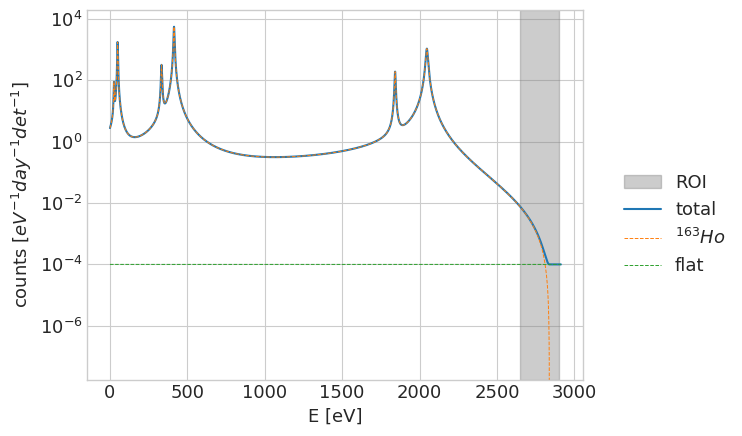

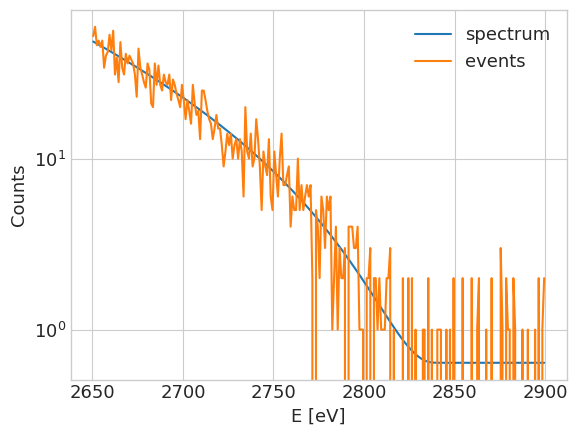

In [2]:
m = 0
A_Ho = 1
bkg = 1e-4
FWHM=5
n_days = 100

s = SpectraSampler({'$^{163}Ho$': [HoSpectrum, [m], A_Ho]}, flat_bkg=bkg, FWHM=FWHM, dE=1, integrate=False)
s.plot_spectrum()
s.set_measure_time(n_days, n_det=64)

events = s.sample()[0]
s.plot_events(events)

### Retrieve and compile the model

In [5]:
stan_file= get_stan_file("Ho_endpoint_simple.stan")
model = CmdStanModel(stan_file=stan_file,
                     **get_compiler_kwargs())

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/163Ho/endpoint_simple/Ho_endpoint_simple.stan


### Fit the model. The steps detailed in the previous examples are run automatically using standard_analysis


 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:417: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:417: RuntimeWarning: divide by zero encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


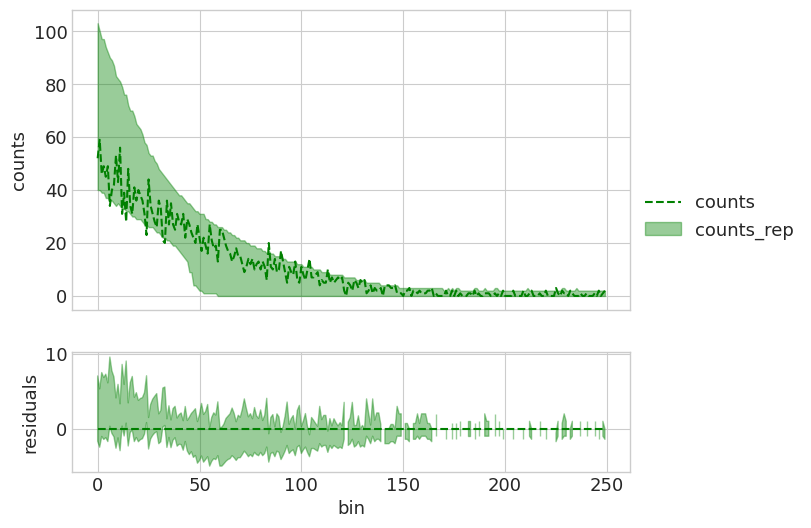


 ---- Prior distribustions ---- 



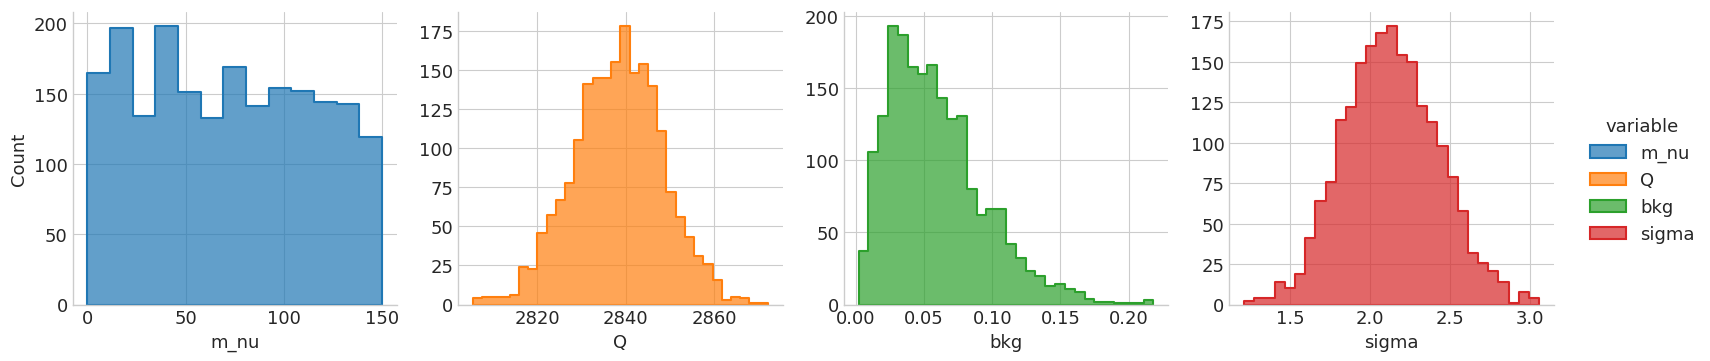


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Processing csv files: /tmp/tmp4g1219ut/Ho_endpoint_simpler145239o/Ho_endpoint_simple-20230726123647_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp4g1219ut/Ho_endpoint_simpler145239o/Ho_endpoint_simple-20230726123647_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp4g1219ut/Ho_endpoint_simpler145239o/Ho_endpoint_simple-20230726123647_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp4g1219ut/Ho_endpoint_simpler145239o/Ho_endpoint_simple-20230726123647_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for div

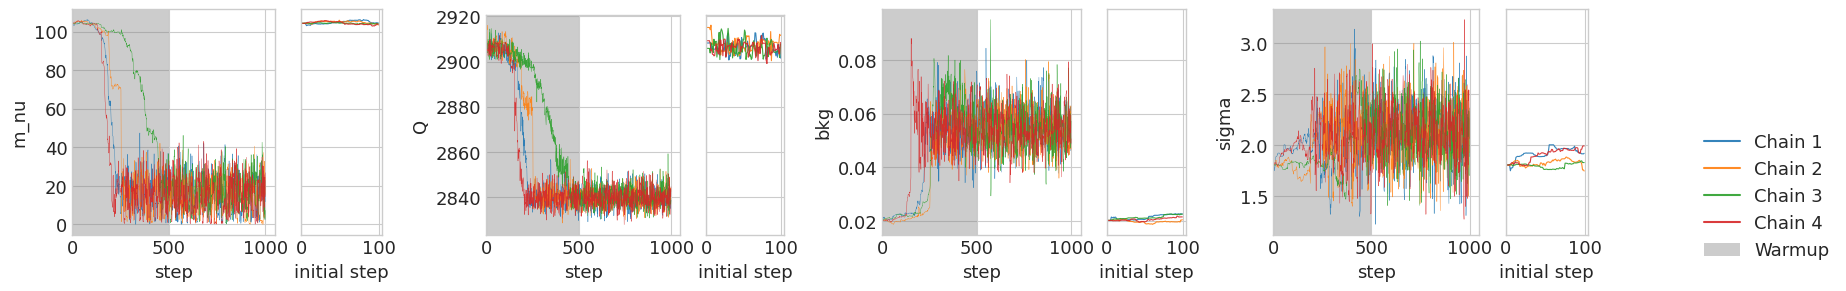


 ---- Prior predictive check ---- 



/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:417: RuntimeWarning: divide by zero encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:417: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


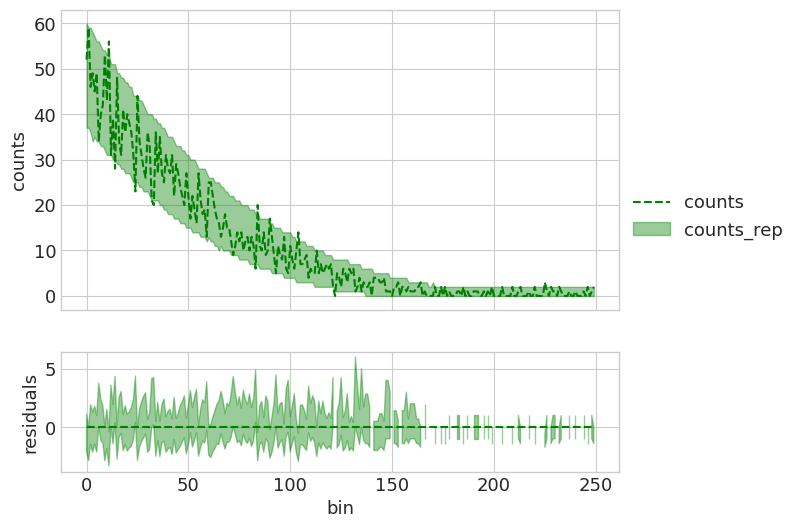


 ---- Posterior distribustions ---- 



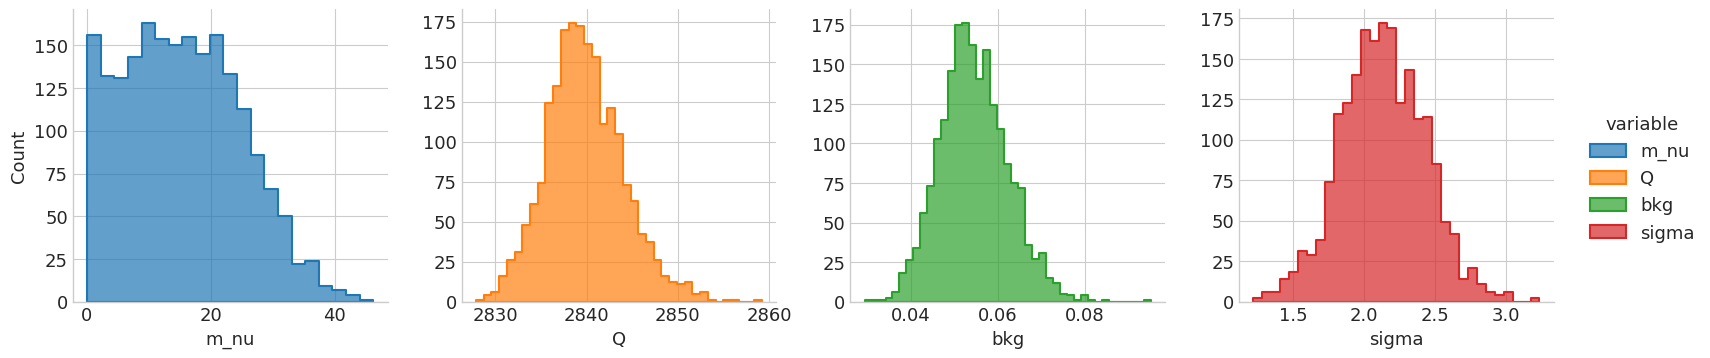


 ---- Prior vs posterior comparison ---- 



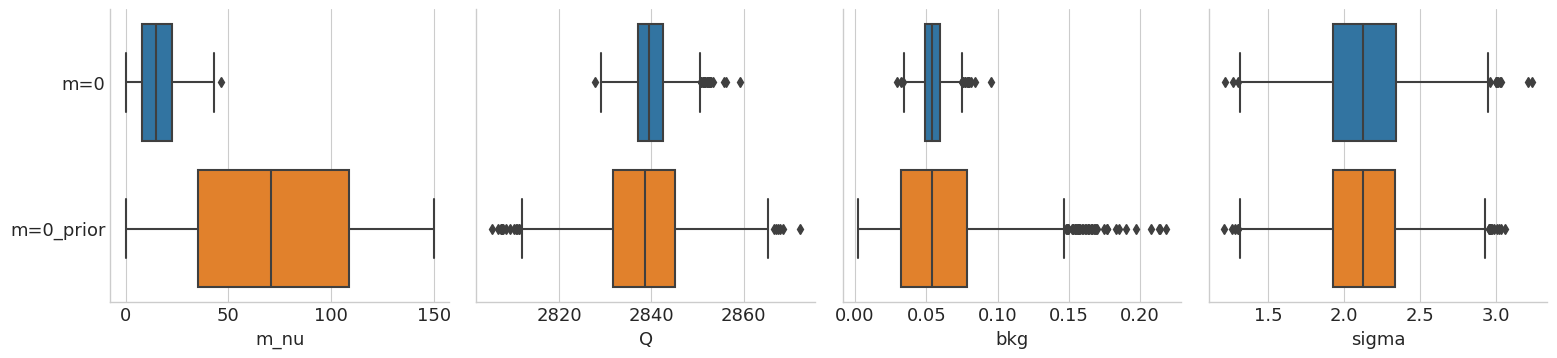

In [6]:
data={'N_bins': len(events), 
      'N_window': 51,
      'x': s.ROI_bin_edges, 
      'counts': events,
      'N_ev': s.n_events,
      'p_Q': 2838,
      'p_FWHM': FWHM,
}

sampler_kwargs={
    'chains': 4,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True, 
    'adapt_delta': 0.9,
    'threads_per_chain':8
}

plot_pars = ['m_nu', 'Q', 'bkg', 'sigma']
p = FitPlotter(col_wrap=4, style='seaborn-v0_8-whitegrid', save=True)
fit = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

### To obtain a robust estimate of the sensibility to $m_\nu$ the fit is repeated many times. This can be done in parallel using multithreaded_run. Result are saved in a .pkl file.

In [13]:
%%time
def nu_mass_fit(m):
    s = SpectraSampler({'$^{163}Ho$': [HoSpectrum, [m], A_Ho]}, flat_bkg=bkg, FWHM=FWHM, dE=1, integrate=False)
    s.set_measure_time(n_days, n_det=64)
    events = s.sample()[0]

    data={'N_bins': len(events), 
          'N_window': 51,
          'x': s.ROI_bin_edges, 
          'counts': events,
          'N_ev': s.n_events,
          'p_Q': 2838,un the model 
          'p_FWHM': 5,
          'prior': 0,
    }
    
    div = True
    while div is True:
        inits={}
        inits['m_nu_red'] = np.random.beta(1,1.05)/3 #the initial value for m_nu shouldn't be too large
        inits['Q'] = np.random.normal(2838, 10)
        inits['bkg'] = np.random.beta(2.5, 20)
        inits['sigma'] = np.random.normal(s.sigma, 0.3)
            
        fit = model.sample(data,
                           chains=2,
                           iter_warmup=500,
                           iter_sampling=1000,
                           save_warmup=False,
                           show_progress=False,
                           inits=inits,
                           adapt_delta=0.9)
        div = any(fit.divergences)
    return fit

n_fits = 100
n_processes = 16
result = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes, filename='data/'+str(m)+'_fits.pkl')

Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number of events in ROI:  2778
Number o

### Open the data file and recover the posteriors for $m_\nu$

In [5]:
pkl_file = open('data/0_fits.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
posteriors = []
for fit in data:
    posteriors.append(fit.draws_pd(['m_nu']).to_numpy().flatten())
posteriors = np.array(posteriors)

### Plot the posteriors and combine their samples in a histogram. The upper limit on the parameter's estimate is given by the confidence interval of this distribution.

68.0% highest density interval:  [9.12898e-03 1.91507e+01]
95.0% highest density interval:  [9.12898e-03 1.91507e+01]


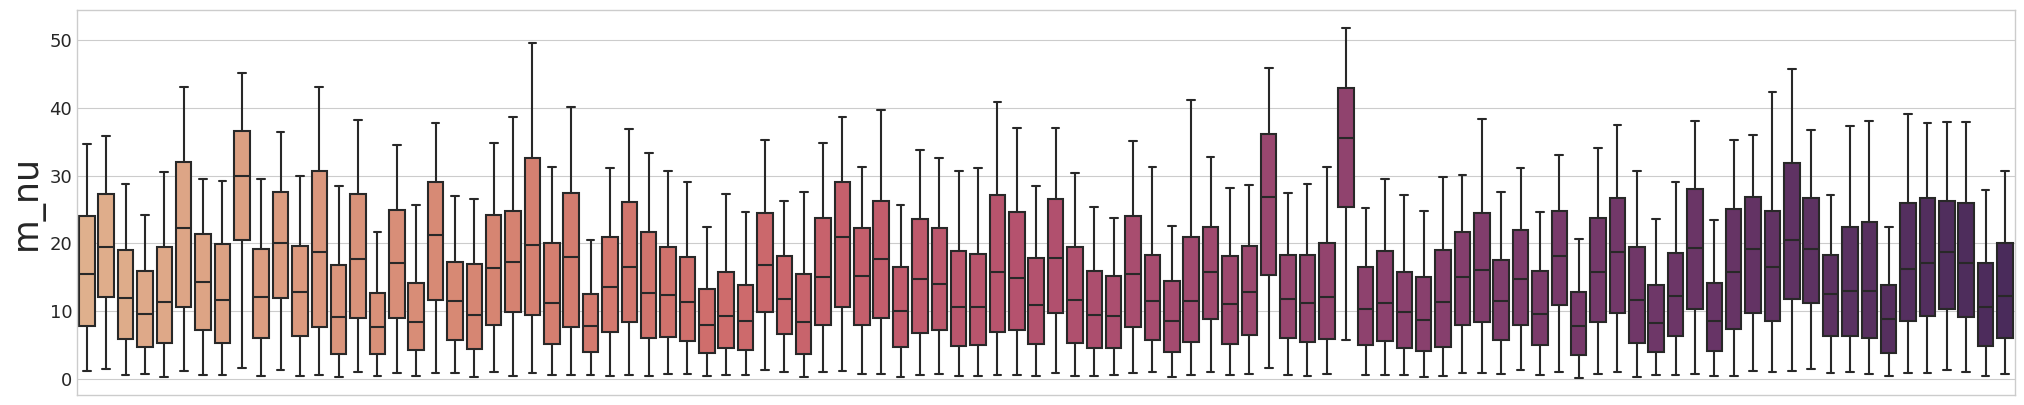

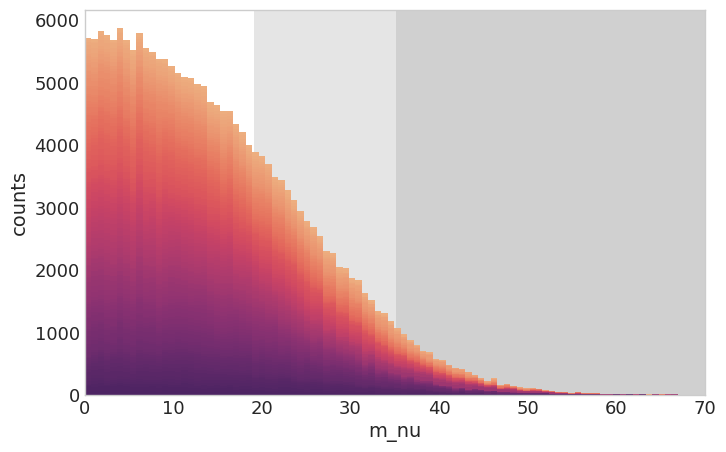

In [6]:
ax = p.new_figure('multi').subplots()
sns.boxplot(posteriors.transpose(), whis=[2.5, 95], showfliers=False, palette='flare', ax=ax)
ax.figure.set_size_inches(25, 5)
ax.set_xticks([])
ax.set_ylabel('m_nu', fontsize=25)


full = posteriors.flatten()
ax = p.new_figure('multi').subplots()
x_max=70

prob = 0.68
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=0.68)) 
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

prob = 0.95
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=0.68)) 
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

sns.histplot(posteriors.transpose(), bins=100, alpha=1, multiple='stack', legend=False, lw=0., palette='flare', ax=ax)
ax.grid(False)
ax.set_xlim(0, x_max)
ax.set_xlabel('m_nu', fontsize=14)
ax.set_ylabel('counts', fontsize=14)
ax.figure.set_size_inches(8, 5)